In [1]:
!pip install pyshark pandas
!pip install nest_asyncio
!apt-get update
!apt-get install -y tshark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.4 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [859 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]


In [2]:
import pyshark
import pandas as pd
import nest_asyncio
import asyncio

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Enable nested asyncio
nest_asyncio.apply()

# Defining the path to the PCAP file
pcap_file_path = '/content/drive/My Drive/pcap/client.pcap'  # Change this to the correct path

# Defining the path to the output CSV file
csv_file_path = '/content/drive/My Drive/pcap/output.csv'

Mounted at /content/drive


In [3]:
timestamps = []
# Define an asynchronous function to capture packets and extract their timestamps
async def capture_packets(pcap_file_path):
    # Open the pcap file using pyshark's FileCapture
    cap = pyshark.FileCapture(pcap_file_path)
    # Iterate through each packet in the capture
    for packet in cap:
        # Check if the packet has a 'sniff_time' attribute (timestamp)
        if hasattr(packet, 'sniff_time'):
            # Append the packet's timestamp (in seconds) to the list
            timestamps.append(packet.sniff_time.timestamp())
    # Close the capture to free up resources
    cap.close()

# Run the packet capture function
await capture_packets(pcap_file_path)

# Convert the list of timestamps to a pandas DataFrame
df = pd.DataFrame(timestamps, columns=['timestamp'])

# Calculate the time difference between consecutive packets
# The first packet's time_diff will be NaN, which we fill with 0
df['time_diff'] = df['timestamp'].diff().fillna(0)

# Print the first 10 rows of the DataFrame to debug
print("Timestamp DataFrame:")
print(df.head(10))

# Define the interval for calculating packets per second (1 second in this case)
interval = 1

# Floor the timestamps to the nearest second to create time intervals
df['time_sec'] = df['timestamp'].floordiv(interval) * interval

# Group by the floored timestamps and count the number of packets in each interval
packets_per_sec = df.groupby('time_sec').size().reset_index(name='packets')

# Save the resulting DataFrame to a CSV file on Google Drive
packets_per_sec.to_csv(csv_file_path, index=False)

# Display the first 10 rows of the resulting DataFrame (optional)
packets_per_sec.head(10)

Timestamp DataFrame:
      timestamp  time_diff
0  1.719825e+09   0.000000
1  1.719825e+09   0.014431
2  1.719825e+09   0.000022
3  1.719825e+09   0.005020
4  1.719825e+09   0.000002
5  1.719825e+09   0.014212
6  1.719825e+09   0.014519
7  1.719825e+09   0.011327
8  1.719825e+09   0.000001
9  1.719825e+09   0.019558


,time_sec,packets
0,1.719825e+09,24
1,1.719825e+09,14
2,1.719825e+09,14
3,1.719825e+09,15
4,1.719825e+09,51
5,1.719825e+09,124
6,1.719825e+09,112
7,1.719825e+09,53
8,1.719825e+09,110
9,1.719825e+09,105


In [4]:
import matplotlib.pyplot as plt

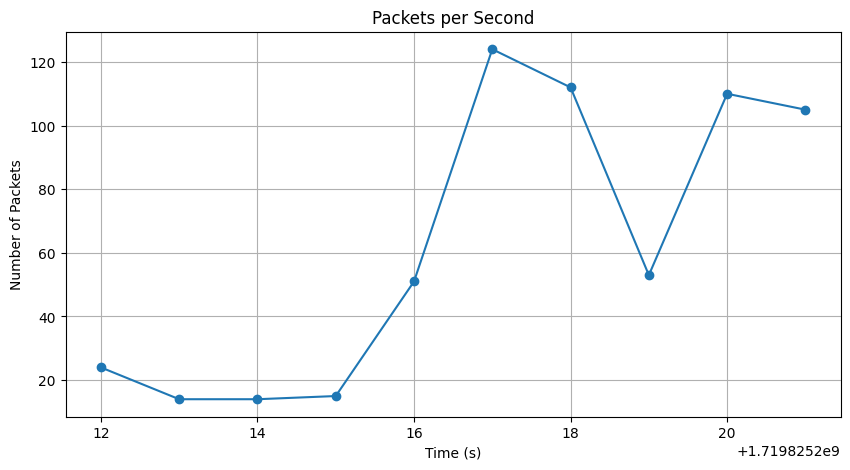

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(packets_per_sec['time_sec'], packets_per_sec['packets'], marker='o')
plt.title('Packets per Second')
plt.xlabel('Time (s)')
plt.ylabel('Number of Packets')
plt.grid(True)
plt.show()